# Speech Emotion Recognition
## PRML Course Project

### Loading the Important libraries and Modules

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import glob
import pickle

from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.metrics import accuracy_score,classification_report

from tensorflow.python.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Add,LSTM,Dense,Conv1D,InputLayer,Activation,InputLayer,BatchNormalization,Flatten,Dropout,Conv1D,MaxPooling1D
from tensorflow.keras.activations import relu,softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu,softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.config.run_functions_eagerly(True)

sc = StandardScaler()
enc = LabelEncoder()
mms = MinMaxScaler()
oh = OneHotEncoder()
sns.set_style('darkgrid')

emotions_encoder = {
    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Happy',
    '04': 'Sad',
    '05': 'Angry',
    '06': 'Fearful',
    '07': 'Disgust',
    '08': 'Surprised'
}

observed_emotions = [x for x in emotions_encoder.values()]

## The created Pipeline <code>Feature()</code> 
### Takes in the series of Paths of the audio files in the device, <br>loads them into time series data in the <code>extract_features()</code> through <code>engineer()</code>function, and further extracts the relevant features out of the time series data by :-
* Frequency Sampling
* Fourier Analysis
* Slope Change for the wave
### All of which is facilitated by <code>extract_feature()</code> and its input parameters.

In [2]:
class Feature():

    def __init__(self, mfcc=True, chroma=True, mel=True, zcr=True, spread=True, mean=True):
        self.mfcc = mfcc
        self.chroma = chroma
        self.mel = mel
        self.zcr = zcr
        self.spread = spread
        self.mean = mean

    def extract_feature(self,file_name,augmented = str()):
        data = []    
        X,sample_rate = librosa.load(path=file_name,duration=2.5,offset=0.5)
        if augmented.lower() == "noised":
            noise_amp = 0.05*np.random.uniform()*np.amax(X)
            X = X + noise_amp*np.random.normal(size=X.shape[0])

        elif augmented.lower() == "stretched":
            X = librosa.effects.time_stretch(X, 0.8)

        elif augmented.lower() == "rolled":
            shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
            X = np.roll(X, shift_range)

        elif augmented.lower() == "pitchedd":
            sampling_rate = self.sampling_rate
            X = librosa.effects.pitch_shift(X, sampling_rate, self.pitch_factor)

        data.append(X)
        self.sample_rate = sample_rate
        result=np.array([])

        if self.mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))

        if self.chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate,n_chroma=32).T,axis=0)
            result=np.hstack((result, chroma))

        if self.mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate,n_fft=2048).T,axis=0)
            result=np.hstack((result, mel))

        if self.zcr:
            Z = np.mean(librosa.feature.zero_crossing_rate(y=X),axis=1)
            result=np.hstack((result, Z))

        if self.spread:
            var = np.var(X)
            result=np.hstack((result, var))

        if self.mean:
            mean = np.mean(X)
            result=np.hstack((result, mean))

        return result

    def engineer(self,Paths=[],augmented = str()):
        X = []        
        self.Paths = Paths
        for file in Paths:
            feature=self.extract_feature(file)
            X.append(feature)
        self.features = X

        return np.array(X)



### Loading the paths in a pandas series and encoding labels to usable formats.

In [3]:
X,Y=[],[]

for file in glob.glob("Data/Actor_*/*.wav"):
    file_name=os.path.basename(file)
    emotion=emotions_encoder[file_name.split("-")[2]]
    X.append(file)
    Y.append(emotion)
Y_ = LabelEncoder().fit_transform(Y)
Y_oh = OneHotEncoder().fit_transform(Y_.reshape(-1,1)).toarray()



#### Class Frequencies

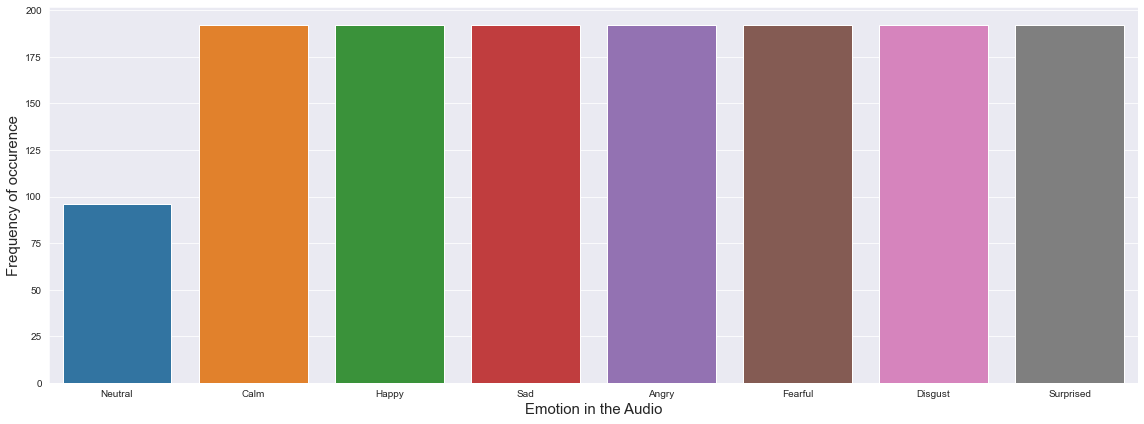

In [4]:
plt.figure(figsize=(16,6))
sns.countplot(x = Y)
plt.ylabel("Frequency of occurence",fontdict={'fontsize':15})
plt.xlabel("Emotion in the Audio",fontdict={'fontsize':15})
plt.tight_layout()
plt.show()

# Loading Data and Models

## ALL Data ( MFCC , Chroma , MEL )

### Loading all the relevant features using the pipeline to train supervised models on them


In [5]:
Feat_all = Feature(spread=False,zcr=False,mean=False)
x_train,x_test,y_train,y_test = train_test_split(X,Y_,train_size=0.8)
Non_Augmented = Feat_all.engineer(x_train)
alltest = Feat_all.engineer(x_test)


### Augmented versions of the Data are loaded too

In [6]:
noised = Feat_all.engineer(x_train,augmented="noised")
stretched = Feat_all.engineer(x_train,augmented='stretched')
rolled = Feat_all.engineer(x_train,augmented='rolled')
pitched = Feat_all.engineer(x_train,augmented='pitched')

## Shallow MLP

In [7]:
def ShallowMLP(Xtrain,Ytrain,Xtest,Ytest):
    mod1=MLPClassifier(hidden_layer_sizes=(256,128,64,32),validation_fraction=0.2,early_stopping=True,learning_rate_init=0.001)
    mod1.fit((sc.fit_transform(Xtrain)),Ytrain)
    print(classification_report(mod1.predict(sc.transform(Xtest)),Ytest))

## SVM (RBF Kernel)

In [8]:
def SVM_Model(Xtrain,Ytrain,Xtest,Ytest):
    svm = SVC(C = 100)
    svm.fit((sc.fit_transform(Xtrain)),Ytrain)
    print(classification_report(svm.predict(sc.transform(Xtest)),Ytest))


## Logistic Regression

In [9]:
def Log_Regressor(Xtrain,Ytrain,Xtest,Ytest):
    LR = LogisticRegression(max_iter=10000)
    LR.fit(sc.fit_transform(Xtrain),Ytrain)
    print(classification_report(LR.predict(sc.transform(Xtest)),Ytest))

## Passive Aggressive Classifier 

In [10]:
def PAClassifier(Xtrain,Ytrain,Xtest,Ytest):
    pac = PassiveAggressiveClassifier(max_iter=10000)
    pac.fit(sc.fit_transform(Xtrain),Ytrain)
    print(classification_report(pac.predict(sc.transform(Xtest)),Ytest))

## K Nearest Neighbour

In [11]:
from sklearn.neighbors import KNeighborsClassifier

def KNN(Xtrain,Ytrain,Xtest,Ytest):
    r = [1]
    acc = []
    for k in r:
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit((sc.fit_transform(Xtrain)),Ytrain)
        print(classification_report(knn.predict(sc.transform(Xtest)),Ytest))   

## One Dimensional CNN

In [12]:
def One_D_CNN(Xtrain,Ytrain,Xtest,Ytest):

    model = Sequential()
    model.add(InputLayer(input_shape=(200,1)))
    model.add(Conv1D(32,3,padding="same",activation=relu))
    model.add(Conv1D(64,3,padding="same",activation=relu))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4,strides=2))
    model.add(Conv1D(128,3,padding="same",activation=relu))
    model.add(Flatten())
    model.add(Dense(8,activation=softmax))
    model.compile(loss=categorical_crossentropy,optimizer=Adam(),metrics="accuracy")
    print(model.summary())

    model.fit(np.expand_dims(sc.fit_transform(Xtrain), -1),to_categorical(Ytrain),
            validation_data=(np.expand_dims(sc.fit_transform(Xtest), -1),to_categorical(Ytest)),
            epochs=40, batch_size=128,)
    y_pred = model.predict(np.expand_dims(sc.fit_transform(Xtest), -1))
    print(classification_report(np.argmax(y_pred, -1), Ytest))


## XGBoost

In [13]:
from xgboost import XGBClassifier
def XGBC(Xtrain,Ytrain,Xtest,Ytest):
    xgb = XGBClassifier()
    xgb.fit(Xtrain,Ytrain)
    Ypred = xgb.predict(Xtest)
    print(classification_report(Ypred,Ytest))



## LSTM Model

In [47]:
def LSTM_model(Xtrain,Ytrain,Xtest,Ytest):
    def create_model_LSTM():
        model = Sequential()
        model.add(LSTM(128, return_sequences=False, input_shape=(Xtrain.shape[1], 1)))
        model.add(Dense(64))
        model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(Dense(32))
        model.add(Dropout(0.4))
        model.add(Activation('relu'))
        model.add(Dense(8,activation=relu))
        model.add(Dense(1))
        model.add(Activation('softmax'))
        model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
        return model

    model = create_model_LSTM()
    model.fit(np.expand_dims(Xtrain,-1),Ytrain,epochs=50)
    ypred = model.predict(np.expand_dims(Xtest,-1))
    print(classification_report(ypred,Ytest))



## SVM on Original Data

In [52]:
rbf_acc_train = []
rbf_acc_test = []
max_const = 50
test = Feat_all.engineer(x_test)
for gen_const in range(0,max_const,2):
    rbf_model = SVC(C=(gen_const+1),kernel='rbf')
    rbf_model.fit(sc.fit_transform(Non_Augmented),y_train)
    rbf_results_train = rbf_model.predict(sc.transform(Non_Augmented))
    rbf_results_test = rbf_model.predict(sc.transform(test))
    rbf_acc_train.append(accuracy_score(rbf_results_train,y_train))
    rbf_acc_test.append(accuracy_score(rbf_results_test,y_test))
rbfm = np.argmax(rbf_acc_test)

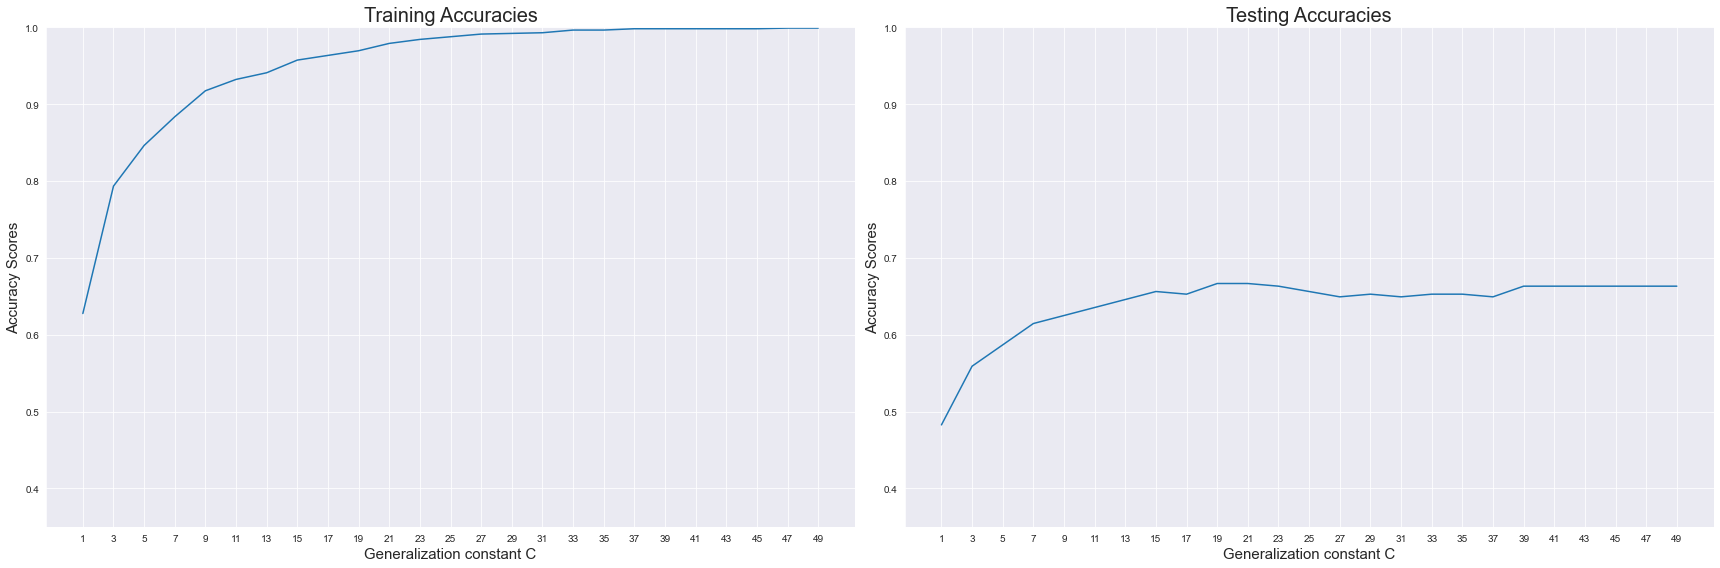

In [53]:
plt.figure('Accuracy plot RBF',figsize=(24,8))

sns.set_style('darkgrid')
plt.subplot(1,2,1)
sns.lineplot(x=[i+1 for i in range(0,max_const,2)],y=rbf_acc_train)
plt.xticks(ticks=[i+1 for i in range(0,max_const,2)])
plt.xlabel("Generalization constant C",fontdict={'fontsize':15})
plt.ylabel("Accuracy Scores",fontdict={'fontsize':15})
plt.ylim([0.35, 1])
plt.title('Training Accuracies',fontdict={'fontsize':20})
plt.tight_layout()

plt.subplot(1,2,2)
sns.lineplot(x=[i+1 for i in range(0,max_const,2)],y=rbf_acc_test)
plt.xticks(ticks=[i+1 for i in range(0,max_const,2)])
plt.xlabel("Generalization constant C",fontdict={'fontsize':15})
plt.ylabel("Accuracy Scores",fontdict={'fontsize':15})
plt.ylim([0.35, 1])
plt.title('Testing Accuracies',fontdict={'fontsize':20})
plt.tight_layout()
plt.show()


# In the following code the models are trained in the order
* Shallow MLP
* SVM
* Logistic Regresseor
* Passive Aggressive Classifier 
* KNN
* One D CNN
* XGBoost
* LSTM


## MFCC


### original Data

In [16]:
Feat_mf = Feature(spread=False,zcr=False,mean=False,chroma=False,mel=False)
mfx_train,mfx_test,mfy_train,mfy_test = train_test_split(X,Y_,train_size=0.8)
mfNon_Augmented = Feat_mf.engineer(mfx_train)
mftest = Feat_mf.engineer(mfx_test)

In [24]:
ShallowMLP(mfNon_Augmented,mfy_train,mftest,mfy_test)

              precision    recall  f1-score   support

           0       0.69      0.71      0.70        34
           1       0.72      0.82      0.77        38
           2       0.68      0.61      0.64        46
           3       0.51      0.68      0.58        31
           4       0.49      0.55      0.52        31
           5       0.48      0.37      0.42        27
           6       0.60      0.55      0.57        44
           7       0.72      0.62      0.67        37

    accuracy                           0.62       288
   macro avg       0.61      0.61      0.61       288
weighted avg       0.62      0.62      0.62       288



In [223]:
SVM_Model(mfNon_Augmented,mfy_train,mftest,mfy_test)

              precision    recall  f1-score   support

           0       0.93      0.68      0.79        41
           1       0.77      0.72      0.74        46
           2       0.68      0.63      0.66        30
           3       0.71      0.64      0.67        45
           4       0.67      0.86      0.76        43
           5       0.48      0.50      0.49        20
           6       0.66      0.75      0.70        28
           7       0.63      0.69      0.66        35

    accuracy                           0.70       288
   macro avg       0.69      0.68      0.68       288
weighted avg       0.71      0.70      0.70       288



In [224]:
Log_Regressor(mfNon_Augmented,mfy_train,mftest,mfy_test)

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        40
           1       0.44      0.49      0.46        39
           2       0.46      0.33      0.39        39
           3       0.29      0.29      0.29        42
           4       0.42      0.66      0.51        35
           5       0.19      0.33      0.24        12
           6       0.50      0.32      0.39        50
           7       0.32      0.39      0.35        31

    accuracy                           0.41       288
   macro avg       0.41      0.41      0.40       288
weighted avg       0.44      0.41      0.41       288



In [225]:
PAClassifier(mfNon_Augmented,mfy_train,mftest,mfy_test)

              precision    recall  f1-score   support

           0       0.33      0.50      0.40        20
           1       0.05      0.29      0.08         7
           2       0.57      0.31      0.41        51
           3       0.15      0.26      0.19        23
           4       0.42      0.35      0.38        65
           5       0.00      0.00      0.00         1
           6       0.41      0.23      0.29        57
           7       0.34      0.20      0.25        64

    accuracy                           0.29       288
   macro avg       0.28      0.27      0.25       288
weighted avg       0.39      0.29      0.32       288



In [226]:
KNN(mfNon_Augmented,mfy_train,mftest,mfy_test)

              precision    recall  f1-score   support

           0       0.73      0.59      0.66        37
           1       0.77      0.77      0.77        43
           2       0.68      0.61      0.64        31
           3       0.61      0.61      0.61        41
           4       0.58      0.80      0.67        40
           5       0.57      0.44      0.50        27
           6       0.56      0.53      0.55        34
           7       0.63      0.69      0.66        35

    accuracy                           0.64       288
   macro avg       0.64      0.63      0.63       288
weighted avg       0.65      0.64      0.64       288



In [227]:
One_D_CNN(mfNon_Augmented,mfy_train.reshape(-1,1),mftest,mfy_test.reshape(-1,1))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 40, 32)            128       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 40, 64)            6208      
_________________________________________________________________
dropout_16 (Dropout)         (None, 40, 64)            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 40, 64)            256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 19, 64)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 19, 128)           24704     
_________________________________________________________________
flatten_12 (Flatten)         (None, 2432)            

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


9/9 [==============================] - 0s 53ms/step - loss: 2.2068 - accuracy: 0.1979 - val_loss: 2.0459 - val_accuracy: 0.2188
Epoch 2/40
9/9 [==============================] - 0s 49ms/step - loss: 1.7576 - accuracy: 0.3238 - val_loss: 2.0237 - val_accuracy: 0.2500
Epoch 3/40
9/9 [==============================] - 0s 49ms/step - loss: 1.5776 - accuracy: 0.4184 - val_loss: 2.0081 - val_accuracy: 0.3472
Epoch 4/40
9/9 [==============================] - 0s 48ms/step - loss: 1.4419 - accuracy: 0.4870 - val_loss: 1.9964 - val_accuracy: 0.3333
Epoch 5/40
9/9 [==============================] - 0s 48ms/step - loss: 1.3129 - accuracy: 0.5295 - val_loss: 1.9766 - val_accuracy: 0.3438
Epoch 6/40
9/9 [==============================] - 0s 50ms/step - loss: 1.2163 - accuracy: 0.5582 - val_loss: 1.9623 - val_accuracy: 0.3889
Epoch 7/40
9/9 [==============================] - 0s 49ms/step - loss: 1.1262 - accuracy: 0.6102 - val_loss: 1.9451 - val_accuracy: 0.3646
Epoch 8/40
9/9 [======================

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [228]:
XGBC(mfNon_Augmented,mfy_train,mftest,mfy_test)

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        36
           1       0.79      0.65      0.72        52
           2       0.46      0.45      0.46        29
           3       0.61      0.60      0.60        42
           4       0.49      0.73      0.59        37
           5       0.43      0.56      0.49        16
           6       0.56      0.41      0.47        44
           7       0.55      0.66      0.60        32

    accuracy                           0.59       288
   macro avg       0.59      0.59      0.58       288
weighted avg       0.61      0.59      0.60       288



In [48]:

LSTM_model(mfNon_Augmented,mfy_train,mftest,mfy_test)

Epoch 1/50
 2/36 [>.............................] - ETA: 2s - loss: 0.0000e+00 - accuracy: 0.1406

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


36/36 [==============================] - 3s 74ms/step - loss: 0.0000e+00 - accuracy: 0.1276
Epoch 2/50
36/36 [==============================] - 3s 74ms/step - loss: 0.0000e+00 - accuracy: 0.1276
Epoch 3/50
36/36 [==============================] - 3s 74ms/step - loss: 0.0000e+00 - accuracy: 0.1276
Epoch 4/50
36/36 [==============================] - 3s 75ms/step - loss: 0.0000e+00 - accuracy: 0.1276
Epoch 5/50
36/36 [==============================] - 3s 76ms/step - loss: 0.0000e+00 - accuracy: 0.1276
Epoch 6/50
24/36 [===================>..........] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.1302ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\backend.py", line 4518, in <genexpr>
    ta.wri

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

## MEL Coefficients

### Original Data

In [184]:
Feat_ml = Feature(spread=False,zcr=False,mean=False,chroma=False,mfcc=False)
mlx_train,mlx_test,mly_train,mly_test = train_test_split(X,Y_,train_size=0.8)
mlNon_Augmented = Feat_ml.engineer(mlx_train)
mltest = Feat_ml.engineer(mlx_test)

In [229]:
ShallowMLP(mlNon_Augmented,mly_train,mltest,mly_test)

              precision    recall  f1-score   support

           0       0.45      0.69      0.55        26
           1       0.66      0.32      0.43        85
           2       0.45      0.39      0.41        44
           3       0.30      0.46      0.36        26
           4       0.14      0.31      0.19        16
           5       0.00      0.00      0.00         0
           6       0.11      0.10      0.11        39
           7       0.39      0.27      0.32        52

    accuracy                           0.34       288
   macro avg       0.31      0.32      0.30       288
weighted avg       0.42      0.34      0.35       288



C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [230]:
SVM_Model(mlNon_Augmented,mly_train,mltest,mly_test)

              precision    recall  f1-score   support

           0       0.55      0.65      0.59        34
           1       0.78      0.33      0.46        98
           2       0.34      0.39      0.37        33
           3       0.23      0.69      0.34        13
           4       0.14      0.31      0.19        16
           5       0.00      0.00      0.00         0
           6       0.31      0.17      0.22        63
           7       0.28      0.32      0.30        31

    accuracy                           0.35       288
   macro avg       0.33      0.36      0.31       288
weighted avg       0.49      0.35      0.38       288



C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [231]:
Log_Regressor(mlNon_Augmented,mly_train,mltest,mly_test)

              precision    recall  f1-score   support

           0       0.33      0.57      0.41        23
           1       0.80      0.36      0.50        91
           2       0.39      0.47      0.43        32
           3       0.30      0.50      0.37        24
           4       0.22      0.27      0.24        30
           5       0.00      0.00      0.00         0
           6       0.23      0.16      0.19        50
           7       0.28      0.26      0.27        38

    accuracy                           0.34       288
   macro avg       0.32      0.32      0.30       288
weighted avg       0.45      0.34      0.36       288



C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [232]:
PAClassifier(mlNon_Augmented,mly_train,mltest,mly_test)

              precision    recall  f1-score   support

           0       0.50      0.47      0.48        43
           1       0.85      0.31      0.45       113
           2       0.05      0.33      0.09         6
           3       0.50      0.21      0.30        94
           4       0.03      0.14      0.05         7
           5       0.05      0.11      0.06         9
           6       0.06      0.17      0.09        12
           7       0.03      0.25      0.05         4

    accuracy                           0.28       288
   macro avg       0.26      0.25      0.20       288
weighted avg       0.58      0.28      0.36       288



In [233]:
KNN(mlNon_Augmented,mly_train,mltest,mly_test)

              precision    recall  f1-score   support

           0       0.42      0.50      0.46        34
           1       0.44      0.64      0.52        28
           2       0.50      0.49      0.49        39
           3       0.33      0.43      0.37        30
           4       0.42      0.38      0.40        39
           5       0.59      0.50      0.54        26
           6       0.43      0.33      0.37        46
           7       0.50      0.39      0.44        46

    accuracy                           0.44       288
   macro avg       0.45      0.46      0.45       288
weighted avg       0.45      0.44      0.44       288



In [ ]:

One_D_CNN(mlNon_Augmented,mly_train,mltest,mly_test)

In [190]:
XGBC(mlNon_Augmented,mly_train,mltest,mly_test)

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:12:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        40
           1       0.66      0.61      0.64        44
           2       0.58      0.45      0.51        49
           3       0.42      0.59      0.49        29
           4       0.39      0.35      0.37        40
           5       0.32      0.44      0.37        16
           6       0.43      0.45      0.44        33
           7       0.47      0.46      0.47        37

    accuracy                           0.51       288
   macro avg       0.50      0.51      0.50       288
weighted avg       0.52      0.51      0.51       288



In [ ]:
LSTM_model(mlNon_Augmented,mly_train,mltest,mly_test)

## Chroma Vectors

### Original Data

In [191]:
Feat_cv = Feature(spread=False,zcr=False,mean=False,mel=False,mfcc=False)
cvx_train,cvx_test,cvy_train,cvy_test = train_test_split(X,Y_,train_size=0.8)
cvNon_Augmented = Feat_cv.engineer(cvx_train)
cvtest = Feat_cv.engineer(cvx_test)

In [192]:
ShallowMLP(cvNon_Augmented,cvy_train,cvtest,cvy_test)

              precision    recall  f1-score   support

           0       0.20      0.16      0.18        44
           1       0.23      0.26      0.25        34
           2       0.15      0.19      0.16        32
           3       0.33      0.30      0.32        40
           4       0.16      0.16      0.16        38
           5       0.04      0.11      0.06         9
           6       0.10      0.12      0.11        34
           7       0.40      0.25      0.30        57

    accuracy                           0.20       288
   macro avg       0.20      0.19      0.19       288
weighted avg       0.23      0.20      0.21       288



In [193]:
SVM_Model(cvNon_Augmented,cvy_train,cvtest,cvy_test)

              precision    recall  f1-score   support

           0       0.23      0.16      0.19        49
           1       0.18      0.24      0.21        29
           2       0.15      0.26      0.19        23
           3       0.25      0.31      0.28        29
           4       0.16      0.13      0.15        45
           5       0.00      0.00      0.00         0
           6       0.07      0.17      0.10        18
           7       0.66      0.24      0.35        95

    accuracy                           0.22       288
   macro avg       0.21      0.19      0.18       288
weighted avg       0.34      0.22      0.24       288



C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [194]:
Log_Regressor(cvNon_Augmented,cvy_train,cvtest,cvy_test)

              precision    recall  f1-score   support

           0       0.23      0.17      0.20        46
           1       0.38      0.31      0.34        48
           2       0.15      0.27      0.19        22
           3       0.14      0.16      0.15        32
           4       0.16      0.25      0.20        24
           5       0.04      0.17      0.06         6
           6       0.12      0.11      0.11        47
           7       0.34      0.19      0.24        63

    accuracy                           0.20       288
   macro avg       0.20      0.20      0.19       288
weighted avg       0.24      0.20      0.21       288



In [195]:
PAClassifier(cvNon_Augmented,cvy_train,cvtest,cvy_test)

              precision    recall  f1-score   support

           0       0.26      0.20      0.23        45
           1       0.13      0.21      0.16        24
           2       0.10      0.22      0.14        18
           3       0.22      0.17      0.20        46
           4       0.05      0.40      0.10         5
           5       0.28      0.11      0.16        63
           6       0.12      0.10      0.11        48
           7       0.11      0.10      0.11        39

    accuracy                           0.15       288
   macro avg       0.16      0.19      0.15       288
weighted avg       0.19      0.15      0.16       288



In [196]:
KNN(cvNon_Augmented,cvy_train,cvtest,cvy_test)

              precision    recall  f1-score   support

           0       0.09      0.09      0.09        34
           1       0.36      0.33      0.34        43
           2       0.22      0.21      0.21        43
           3       0.36      0.42      0.39        31
           4       0.05      0.07      0.06        27
           5       0.16      0.20      0.18        20
           6       0.30      0.29      0.29        42
           7       0.26      0.19      0.22        48

    accuracy                           0.23       288
   macro avg       0.22      0.22      0.22       288
weighted avg       0.24      0.23      0.23       288



In [ ]:
One_D_CNN(cvNon_Augmented,cvy_train,cvtest,cvy_test)

In [197]:
XGBC(cvNon_Augmented,cvy_train,cvtest,cvy_test)

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:13:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.14      0.18      0.16        28
           1       0.31      0.32      0.31        38
           2       0.29      0.28      0.29        43
           3       0.33      0.36      0.35        33
           4       0.19      0.16      0.17        44
           5       0.04      0.09      0.06        11
           6       0.30      0.29      0.29        42
           7       0.37      0.27      0.31        49

    accuracy                           0.26       288
   macro avg       0.25      0.24      0.24       288
weighted avg       0.27      0.26      0.26       288



In [ ]:
LSTM_model(cvNon_Augmented,cvy_train,cvtest,cvy_test)

# Training on Comined Data

## Original

In [239]:
ShallowMLP(Non_Augmented,y_train,alltest,y_test)

              precision    recall  f1-score   support

           0       0.66      0.57      0.61        37
           1       0.74      0.64      0.68        44
           2       0.71      0.67      0.69        48
           3       0.56      0.56      0.56        36
           4       0.32      0.48      0.39        25
           5       0.43      0.43      0.43        21
           6       0.55      0.55      0.55        42
           7       0.59      0.63      0.61        35

    accuracy                           0.58       288
   macro avg       0.57      0.56      0.56       288
weighted avg       0.60      0.58      0.59       288



In [240]:
SVM_Model(Non_Augmented,y_train,alltest,y_test)

              precision    recall  f1-score   support

           0       0.81      0.59      0.68        44
           1       0.79      0.68      0.73        44
           2       0.73      0.73      0.73        45
           3       0.67      0.67      0.67        36
           4       0.43      0.62      0.51        26
           5       0.48      0.53      0.50        19
           6       0.64      0.59      0.61        46
           7       0.51      0.68      0.58        28

    accuracy                           0.64       288
   macro avg       0.63      0.63      0.63       288
weighted avg       0.67      0.64      0.65       288



In [241]:
Log_Regressor(Non_Augmented,y_train,alltest,y_test)

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        39
           1       0.66      0.57      0.61        44
           2       0.58      0.60      0.59        43
           3       0.58      0.53      0.55        40
           4       0.27      0.43      0.33        23
           5       0.33      0.35      0.34        20
           6       0.40      0.34      0.37        50
           7       0.49      0.62      0.55        29

    accuracy                           0.52       288
   macro avg       0.51      0.51      0.51       288
weighted avg       0.54      0.52      0.52       288



In [242]:
PAClassifier(Non_Augmented,y_train,alltest,y_test)

              precision    recall  f1-score   support

           0       0.59      0.51      0.55        37
           1       0.66      0.49      0.56        51
           2       0.42      0.61      0.50        31
           3       0.56      0.43      0.49        46
           4       0.22      0.22      0.22        37
           5       0.05      0.17      0.07         6
           6       0.36      0.60      0.45        25
           7       0.65      0.44      0.52        55

    accuracy                           0.45       288
   macro avg       0.44      0.43      0.42       288
weighted avg       0.51      0.45      0.47       288



In [243]:
KNN(Non_Augmented,y_train,alltest,y_test)

              precision    recall  f1-score   support

           0       0.56      0.56      0.56        32
           1       0.61      0.74      0.67        31
           2       0.76      0.76      0.76        45
           3       0.64      0.64      0.64        36
           4       0.49      0.53      0.51        34
           5       0.71      0.62      0.67        24
           6       0.60      0.57      0.58        44
           7       0.73      0.64      0.68        42

    accuracy                           0.64       288
   macro avg       0.64      0.63      0.63       288
weighted avg       0.64      0.64      0.64       288



In [244]:
One_D_CNN(Non_Augmented,y_train,alltest,y_test)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 200, 32)           128       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 200, 64)           6208      
_________________________________________________________________
dropout_18 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 200, 64)           256       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 99, 64)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 99, 128)           24704     
_________________________________________________________________
flatten_14 (Flatten)         (None, 12672)           

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


9/9 [==============================] - 1s 117ms/step - loss: 2.2319 - accuracy: 0.2413 - val_loss: 1.9783 - val_accuracy: 0.2604
Epoch 2/40
9/9 [==============================] - 1s 115ms/step - loss: 1.5829 - accuracy: 0.4132 - val_loss: 1.9586 - val_accuracy: 0.3090
Epoch 3/40
9/9 [==============================] - 1s 118ms/step - loss: 1.3666 - accuracy: 0.4844 - val_loss: 1.9215 - val_accuracy: 0.3264
Epoch 4/40
9/9 [==============================] - 1s 114ms/step - loss: 1.2172 - accuracy: 0.5443 - val_loss: 1.8829 - val_accuracy: 0.3646
Epoch 5/40
9/9 [==============================] - 1s 114ms/step - loss: 1.1067 - accuracy: 0.6024 - val_loss: 1.8553 - val_accuracy: 0.3785
Epoch 6/40
9/9 [==============================] - 1s 113ms/step - loss: 1.0248 - accuracy: 0.6259 - val_loss: 1.8389 - val_accuracy: 0.3646
Epoch 7/40
9/9 [==============================] - 1s 114ms/step - loss: 0.9114 - accuracy: 0.6667 - val_loss: 1.8301 - val_accuracy: 0.4271
Epoch 8/40
9/9 [===============

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [205]:
XGBC(Non_Augmented,y_train,alltest,y_test)

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        31
           1       0.89      0.63      0.74        54
           2       0.69      0.76      0.72        41
           3       0.64      0.74      0.69        31
           4       0.51      0.50      0.51        38
           5       0.38      0.47      0.42        17
           6       0.67      0.65      0.66        43
           7       0.57      0.64      0.60        33

    accuracy                           0.65       288
   macro avg       0.63      0.64      0.63       288
weighted avg       0.67      0.65      0.65       288



In [ ]:
LSTM_model(Non_Augmented,y_train,alltest,y_test)

## Augmented

In [25]:
ShallowMLP(np.r_[Non_Augmented,noised,rolled,stretched,pitched],np.r_[y_train,y_train,y_train,y_train,y_train],alltest,y_test)

              precision    recall  f1-score   support

           0       0.56      0.83      0.67        23
           1       0.92      0.65      0.76        52
           2       0.62      0.68      0.65        34
           3       0.55      0.70      0.62        37
           4       0.59      0.56      0.58        39
           5       0.53      0.43      0.47        21
           6       0.59      0.61      0.60        36
           7       0.79      0.72      0.75        46

    accuracy                           0.65       288
   macro avg       0.64      0.65      0.64       288
weighted avg       0.67      0.65      0.66       288



In [26]:
SVM_Model(np.r_[Non_Augmented,noised,rolled,stretched,pitched],np.r_[y_train,y_train,y_train,y_train,y_train],alltest,y_test)

              precision    recall  f1-score   support

           0       0.76      0.65      0.70        40
           1       0.86      0.67      0.75        48
           2       0.57      0.68      0.62        31
           3       0.74      0.83      0.79        42
           4       0.49      0.64      0.55        28
           5       0.53      0.47      0.50        19
           6       0.59      0.63      0.61        35
           7       0.74      0.69      0.71        45

    accuracy                           0.67       288
   macro avg       0.66      0.66      0.65       288
weighted avg       0.69      0.67      0.68       288



In [210]:
Log_Regressor(np.r_[Non_Augmented,noised,rolled,stretched,pitched],np.r_[y_train,y_train,y_train,y_train,y_train],alltest,y_test)

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        40
           1       0.55      0.50      0.53        42
           2       0.53      0.59      0.56        41
           3       0.61      0.50      0.55        44
           4       0.32      0.44      0.38        27
           5       0.33      0.37      0.35        19
           6       0.40      0.39      0.40        44
           7       0.46      0.55      0.50        31

    accuracy                           0.50       288
   macro avg       0.50      0.49      0.49       288
weighted avg       0.52      0.50      0.51       288



In [211]:
PAClassifier(np.r_[Non_Augmented,noised,rolled,stretched,pitched],np.r_[y_train,y_train,y_train,y_train,y_train],alltest,y_test)

              precision    recall  f1-score   support

           0       0.59      0.58      0.58        33
           1       0.50      0.43      0.46        44
           2       0.58      0.47      0.52        55
           3       0.47      0.40      0.43        43
           4       0.35      0.43      0.39        30
           5       0.29      0.35      0.32        17
           6       0.24      0.33      0.28        30
           7       0.41      0.42      0.41        36

    accuracy                           0.43       288
   macro avg       0.43      0.43      0.42       288
weighted avg       0.45      0.43      0.44       288



In [212]:
KNN(np.r_[Non_Augmented,noised,rolled,stretched,pitched],np.r_[y_train,y_train,y_train,y_train,y_train],alltest,y_test)

              precision    recall  f1-score   support

           0       0.56      0.56      0.56        32
           1       0.61      0.74      0.67        31
           2       0.76      0.76      0.76        45
           3       0.64      0.64      0.64        36
           4       0.49      0.53      0.51        34
           5       0.71      0.62      0.67        24
           6       0.60      0.57      0.58        44
           7       0.73      0.64      0.68        42

    accuracy                           0.64       288
   macro avg       0.64      0.63      0.63       288
weighted avg       0.64      0.64      0.64       288



In [249]:
One_D_CNN(np.r_[Non_Augmented,noised,rolled,stretched,pitched],np.r_[y_train,y_train,y_train,y_train,y_train],alltest,y_test)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 200, 32)           128       
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 200, 64)           6208      
_________________________________________________________________
dropout_21 (Dropout)         (None, 200, 64)           0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 200, 64)           256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 99, 64)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 99, 128)           24704     
_________________________________________________________________
flatten_17 (Flatten)         (None, 12672)           

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


45/45 [==============================] - 5s 103ms/step - loss: 1.4785 - accuracy: 0.4616 - val_loss: 1.8686 - val_accuracy: 0.3299
Epoch 2/40
45/45 [==============================] - 5s 104ms/step - loss: 0.8534 - accuracy: 0.7031 - val_loss: 1.7682 - val_accuracy: 0.4479
Epoch 3/40
45/45 [==============================] - 5s 101ms/step - loss: 0.5096 - accuracy: 0.8335 - val_loss: 1.6861 - val_accuracy: 0.4271
Epoch 4/40
45/45 [==============================] - 5s 101ms/step - loss: 0.3078 - accuracy: 0.9073 - val_loss: 1.6347 - val_accuracy: 0.4236
Epoch 5/40
45/45 [==============================] - 5s 102ms/step - loss: 0.1795 - accuracy: 0.9550 - val_loss: 1.6712 - val_accuracy: 0.3715
Epoch 6/40
45/45 [==============================] - 5s 101ms/step - loss: 0.1233 - accuracy: 0.9715 - val_loss: 1.6631 - val_accuracy: 0.4271
Epoch 7/40
45/45 [==============================] - 5s 101ms/step - loss: 0.0895 - accuracy: 0.9807 - val_loss: 1.6703 - val_accuracy: 0.4583
Epoch 8/40
45/45 

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [213]:
XGBC(np.r_[Non_Augmented,noised,rolled,stretched,pitched],np.r_[y_train,y_train,y_train,y_train,y_train],alltest,y_test)

C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Aaditya Baranwal\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        31
           1       0.87      0.63      0.73        52
           2       0.64      0.71      0.67        41
           3       0.61      0.71      0.66        31
           4       0.54      0.56      0.55        36
           5       0.48      0.50      0.49        20
           6       0.62      0.55      0.58        47
           7       0.54      0.67      0.60        30

    accuracy                           0.64       288
   macro avg       0.63      0.63      0.63       288
weighted avg       0.65      0.64      0.64       288



## END